# A guide to neuroimaging meta-analysis

## Foreword

In neuroimaging, meta-analysis is an essential tool to increase data power and to face the recurrent issue of the reproductibility of studies which are often conducted on a small number of subjects.  
This notebook gathers and explains some well known meta-analysis techniques, discusses their limitations and applies them to real fMRI data. Neuroimaging meta-analysis are divided into two types : coordinate-based meta-analysis (CBMA) and image-based meta-analysis (IBMA), so is this notebook.

**Warning**:  
In order to illustrate the techniques on real data, operations have been coded in an **inefficient** way in this notebook for the sake of clarity. Do not reuse the provided code for real analysis. Those techniques has been coded in a more efficient and complete way in the python's NiMARE package. The use of this package is strongly recommanded and illustrated at the end of the notebook. 

## Data

Before getting to the heart of the matter, let's load the data which will be used to illustrate the techniques. On first reading one can jump to the next section: **Coordinate-based meta-analysis**.

In [1]:
%matplotlib inline
import os
import multiprocessing
from joblib import Parallel, delayed
import nilearn
import numpy as np
from nilearn import masking, plotting
from nipy.labs.statistical_mapping import get_3d_peaks
import nibabel as nib
import scipy
from matplotlib import pyplot as plt
import ntpath
from nimare.dataset import Dataset
import nimare
import copy

# Some global variables used in the notebook
input_dir = 'data-narps/proc/'  # Processed studies' directory
template = nilearn.datasets.load_mni152_template()
Ni, Nj, Nk = template.shape
affine = template.affine
gray_mask = masking.compute_gray_matter_mask(template)

/Users/alexandreperez/OneDrive/Documents/Stage/McGill/meta_ALE/venv/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/Users/alexandreperez/OneDrive/Documents/Stage/McGill/meta_ALE/venv/lib/python3.7/importlib/_bootstrap_external.py:1043: FutureWarning: Module nipy.labs.utils.routines deprecated, will be removed
  _imp.create_dynamic, spec)
/Users/alexandreperez/OneDrive/Documents/Stage/McGill/meta_ALE/nipy/nipy/labs/statistical_mapping.py:15: FutureWarning: Module nipy.labs.glm deprecated, will be removed. Please use nipy.modalities.fmri.glm instead.
  from .glm import glm
/Users/alexandreperez/OneDri

### Load images

The data follow the following structure:
```
root/
    meta_analysis.ipynb
    data-narps/
        ...
        proc/
            hypo1_unthresh_0.nii.gz
            hypo1_unthresh_1.nii.gz
            hypo1_unthresh_2.nii.gz
            ...
```
Where `hypo1_unthresh_i.nii.gz` is the z map file of the i-th study.

Let's load those maps. In order to make it faster for the notebook to execute, we keep only the first 10 studies in the data folder.

In [2]:
N_img = 10
img_paths = [os.path.abspath(f'{input_dir}hypo1_unthresh_{i}.nii.gz') for i in range(N_img)]

### Extract peaks

The provided data contain only the full brain images. That's perfect for image-based meta-analysis methods but not for coordinate-based ones. Therefore, for informative purpose only, we need to extract from those images the activations peaks' coordinates. Then we will be able to run also coordinate-based meta-analysis methods on the provided data.

To do so, we use the `get_3D_peaks` function of the `nipy.labs.statistical_mapping` module of the `nipy` package.

In [3]:
def get_activations(path, threshold, space='ijk'):
    """
    Retrieve the xyz activation coordinates from an image.

    Args:
        path (string or Nifti1Image): Path to or object of a
            nibabel.Nifti1Image from which to extract coordinates.
        threshold (float): Same as the extract_from_paths function.
        space (string): Space of coordinates. Available : 'ijk' and 'pos'.

    Returns:
        (tuple): Size 3 tuple of lists storing respectively the X, Y and
            Z coordinates

    """
    I, J, K = [], [], []
    try:
        img = nilearn.image.load_img(path)
    except ValueError:  # File path not found
        print(f'File {path} not found. Ignored.')
        return None

    if np.isnan(img.get_fdata()).any():
        print(f'Img {path} contains Nan. Ignored.')
        return None

    img = nilearn.image.resample_to_img(img, template)

    peaks = get_3d_peaks(img, mask=gray_mask, threshold=threshold)

    if not peaks:
        return I, J, K

    for peak in peaks:
        I.append(peak[space][0])
        J.append(peak[space][1])
        K.append(peak[space][2])

    del peaks
    
    I, J, K = np.array(I), np.array(J), np.array(K)
    if space == 'ijk':
        I, J, K = I.astype(int), J.astype(int), K.astype(int)
        
    return I, J, K

In [4]:
activation_peaks = [get_activations(path, 1.96, space='ijk') for path in img_paths]

We turn activation peaks' coordinates into a more practical data structure: binary Nifti images.

In [5]:
binary_imgs = []
for I, J, K in activation_peaks:
    arr = np.zeros(template.shape)
    arr[I, J, K] = 1
    img = nib.Nifti1Image(arr, affine)
    binary_imgs.append(img)

Now that the data is properly loaded, let's talk about meta-analysis techniques!

## Coordinate-based meta-analysis (CBMA)

The first type of neuroimaging techniques is coordinate-based meta-analysis. Those techniques only use a list of brain activation coordinates (which can be seen as binary maps) as input. Thos techniques are used in the following context.

**Context**:  
One have $N$ experiments which deal with the same or related task/topic. For each of those experiments, you have a list of coordinates of activation peaks in the brain. You want to combine those results to build a common activation map in the hope of having a stronger prior on the activation areas of a given task than each experiment can give individually.

### ALE

The key idea of the Activation Likelihood Estimation (ALE) algorithm is to consider the activation foci not in a discrete way but rather as a center of probability distribution.

#### Notations:
- $N$: Number of experiments/studies.
- $S_n$: Number of subjects in the experiment $n$.
- $F_n$: Number of foci in the experiment $n$.


#### Pipeline
The ALE pipeline is summarized in figure [1](#ALE) and can be described as follow.

1. First of all, gather the reported activation peaks in $N$ binary maps.
2. For each of those maps, apply the following pipeline.  
    a. Consider each focus individually and convolve them with a gaussian kernel. Note that the width of the gaussian kernel depends on the number of subjects in the considered experiment.  
    b. Merge the obtained probability maps into a single one called Modeled Activation (MA) map. (Merge method detailled later.)
3. Merge all the MA maps into a single one which give the wanted ALE map. (Merge method detailled later.)

![ALE](resource/ALE_v2.png)
<a id='ALE'></a>

**Figure 1**: The ALE pipeline. The input are coordinates of activation peaks labelled by a study ID so that N binary maps can be built.

3 points remain unclear for now:
- How the gaussian kernel depend on the number of subjects.
- How to merge probability maps into MA maps (labeled by 1 in figure 1).
- How to merge MA maps into an ALE map (labeled by 2 in figure 1).

Let's clarify those points.

#### ALE Kernel

The idea of having a kernel depending on the number of subjects of an experiment is to express the fact that an experiment with a low number of subjects has more uncertainty than an experiment with a high number of subjects. Then, the lower an experiment has subjects, the greater is the FWHM of the gaussian kernel.

#### Merge probability maps

Why do we split the binary map into as many maps as foci, leaving only one focus in each map, to finally merge them together ? The convolution is linear right, why don't we simply convolve the full binary map ?  
Well, the answer is we don't apply a linear operation to merge the probability maps. Basically, the MA map is derived from the probability maps by taking the maximum of all the probability maps element-wise. 

#### Merge MA maps

To understand how the MA maps are merged together into the ALE map, we first have to remember what is the meaning of the MA maps and what do we want to express in the ALE map.

Remember that the key point of ALE is to see the discrete foci as the centers of probability distributions. Hence, the MA map of an experiment can be thought as a rational modelisation of the distribution of the peaks of the experiment. More specifically, the value associated with a given coordinates (i, j, k) represent the likelihood that an activation peak lies on this coordinate.
If we denote $MA_n$ the MA map associated with the experiment $n$, $MA_n(i, j, k) = P(\mbox{ijk activated in the experiment $n$})$

A rational expectation for a meta-analysis map such as ALE is to give us the likelihood that a given coordinate $ijk$ is truly activated in at least one experiment. Hence, if we denote $ALE$ the ALE map :
$$
\begin{equation} \label{eq1}
    \begin{split}
    ALE(i,j,k) & = P(\mbox{$ijk$ activated by at least one experiment}) \\
     & = 1 - P(\mbox{$ijk$ not activated by any experiment}) \\
     & = 1 - P(\mbox{For each experiment $n$, $ijk$ not activated in $MA_n$}) \\
     & = 1 - \prod_{n=1}^{N}P(\mbox{$ijk$ not activated in $MA_n$}) \\
     & = 1 - \prod_{n=1}^{N}(1-P(\mbox{$ijk$ activated in $MA_n$})) \\
     & = 1 - \prod_{n=1}^{N}(1 - MA_n(i,j,k))
    \end{split}
\end{equation}
$$

That's how the ALE map is derived from the MA maps.

#### Mathematic recap

For the sake of simplicity and to be closer to the implementation, we will consider the mathematical objects directly in the discrete 3D brain space rather than the continuous case.

We recall the previous notations:
- $N$: Number of experiments/studies.
- $S_n$: Number of subjects in the experiment $n$.
- $F_n$: Number of foci in the experiment $n$.

And add new ones:
- Let $(N_i, N_j, N_k)$ be the shape of the brain space. Typically $(N_i, N_j, N_k) = (91, 109, 91)$ in the MNI space.
- For all $n \in [1 .. N],$
    * let $B_n \in \{0, 1\}^{N_iN_jN_k}$ be the binary map associated with experiment $n$.
    * let $D_{p, n} \in \{0, 1\}^{N_iN_jN_k}$ be the binary dirac map associated with experiment $n$ and focus $p$ for all $p \in [1 .. F_n]$. In other word a null map with only the position of the focus $p$ set to 1 (called dirac map on figure [1](#ALE)).
    * let $MA_n \in \mathbb{R}^{N_iN_jN_k}$ be the Modeled Activation map of experiment $n$.
    * let $G_{S_n}$ be the gaussian kernel associated with experiment $n$.
- Let $ALE \in \mathbb{R}^{N_iN_jN_k}$ be the wanted ALE map.

Given those notations and what has been said before, we have the following: 

$$
\begin{equation}
    B_n(i, j, k) = \sum_{p=1}^{F_n}D_{p, n}(i, j, k)
\end{equation}
$$

$$
\begin{equation}
    MA_n(i, j, k) = \underset{n \in [1..N]}{\text{max}} \Big[(D_{p, n}*G_{S_n})(i, j, k)\Big]
\end{equation}
$$

$$
\begin{equation}
    ALE(i, j, k) = 1 - \prod_{n=1}^{N}(1 - MA_n(i,j,k))
\end{equation}
$$

$$
\begin{equation}
    ALE = 1 - \prod_{n=1}^{N}(1 - M_n)
\end{equation}
$$

#### Inefficient python implementation

In [6]:
sigma = 2.

def compute_ale_ma_maps():
    ma_maps = np.zeros((N_img, Ni, Nj, Nk))

    for n in range(N_img):
        print(f'{n+1} out of {N_img}', end='\r')
        binary_img = binary_imgs[n]
        
        # Create probability maps
        binary_arr = binary_img.get_fdata()
        nz_i, nz_j, nz_k = np.nonzero(binary_arr)
        prob_arrs = np.zeros((len(nz_i), Ni, Nj, Nk))
        
        for i in range(len(nz_i)):
            prob_arrs[i, nz_i[i], nz_j[i], nz_k[i]] = 1
            # Gaussian convolve
            prob_arrs[i, :, :, :] = scipy.ndimage.gaussian_filter(prob_arrs[i, :, :, :], sigma=sigma)

        # Merge probability maps
        ma_maps[n, :, :, :] = np.max(prob_arrs, axis=0)
        
    return ma_maps


def merge_ale_ma_maps(ma_maps):
    return 1 - np.prod(1-ma_maps, axis=0)

ale_ma_maps = compute_ale_ma_maps()
ale_arr = merge_ale_ma_maps(ale_ma_maps)
ale_img = nib.Nifti1Image(ale_arr, affine)

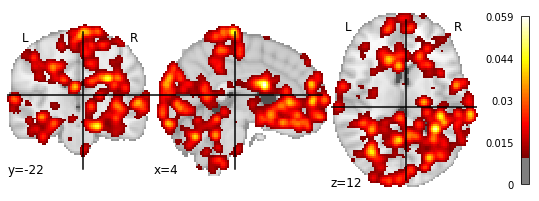

In [7]:
plotting.plot_stat_map(ale_img, threshold=0.01)
plt.show()

### KDA

The Kernel Density Analysis (KDA) technique differs from ALE in the way peaks are considered. Whereas a probability map was derived from the peaks in ALE, in KDA, the value of interest is the peak density (namely the number of peaks lying in a sphere of a given radius).

#### Pipeline
The KDA pipeline is quite similar to the ALE one, the few differences being the kernel and the way maps are merged together.

The pipeline is summarized in figure [2](#KDA) and can be described as follow.

1. First of all, gather the reported activation peaks in $N$ binary maps.
2. Convolve each of those maps with a spherical kernel of ones to build the Modeled Activity (MA) maps.
3. Derive the KDA map by summing the MA maps together.

![ALE](resource/KDA.png)
<a id='KDA'></a>

The first thing we see is that the KDA process is simpler than the ALE one. Indeed, in KDA, the merge operation number 1 of ALE (the non linear maximum element-wise) is replaced by a sum operation element-wise which is linear. So, in KDA we can mix all those steps into a single convolution of the binary map.

The second merge operation (#2 in figure [2](#KDA)) is replaced, here again, by a sum element-wise.

Let's give a bit of interpretation of the different parts in KDA.

#### KDA Kernel

As previously stated, the KDA kernel is a sphere with a chosen radius $r$ of ones and zero else-where. Therefore, the result of a convolution of a dirac map (i.e a zero-valued map with a single one) with this kernel is simply a sphere of ones of same radius.  
The derived map express a density. For each coordinates, the value stored in this map gives the number of peaks lying at most at a distance of $r$ from the chosen coordinate. In the particular case of a dirac map, the derived density is 0 when we look further than $r$ of the unique peak and 1 when we look closer than a $r$ distance from the unique peak.

#### MA maps

From the previous point, the result of a convolution of a binary map (i.e a sum of dirac maps) with the KDA Kernel of radius $r$ express simply the density of the binary map with a radius $r$.

#### KDA map

Here again, since the merge operation #2 is just a sum, the KDA map express a density with a radius $r$ accross studies. That is to say the number of peak lying at most at a distance of $r$.

#### Mathematic recap

- Let $(N_i, N_j, N_k)$ be the shape of the brain space. Typically $(N_i, N_j, N_k) = (91, 109, 91)$ in the MNI space.
- For all $n \in [1 .. N],$
    * let $B_n \in \{0, 1\}^{N_iN_jN_k}$ be the binary map associated with experiment $n$.
    * let $MA_n \in \mathbb{R}^{N_iN_jN_k}$ be the Modeled Activation map of experiment $n$.
    * let $K_r$ be the uniform kernel of size $r$ associated with experiment $n$.
- Let $KDA \in \mathbb{R}^{N_iN_jN_k}$ be the wanted KDA map.

$$
\begin{equation}
    MA_n = B_n*K_r
\end{equation}
$$

$$
\begin{equation}
    KDA(i, j, k) = \sum_{n=1}^NMA_n(i, j, k)
\end{equation}
$$

#### Inefficient python implementation

In [8]:
r = 15. # mm

def uniform_kernel(r, affine):
    A, B, C = r, r, r
    
    a = int(A/abs(affine[0, 0]))
    b = int(B/abs(affine[1, 1]))
    c = int(C/abs(affine[2, 2]))
    
    kernel = np.zeros((2*a+1, 2*b+1, 2*c+1))
    
    i0, j0, k0 = a, b, c
    
    for i in range(2*a+1):
        for j in range(2*b+1):
            for k in range(2*c+1):
                if ((i-i0)/a)**2 + ((j-j0)/b)**2 + ((k-k0)/c)**2 <= 1:
                    kernel[i, j, k] = 1
                
    return kernel


def compute_kda_ma_maps():
    ma_maps = np.zeros((N_img, Ni, Nj, Nk))

    for n in range(N_img):
        print(f'{n+1} out of {N_img}', end='\r')
        binary_img = binary_imgs[n]
        
        # Create probability maps
        binary_arr = binary_img.get_fdata()
        
        prob_arrs = scipy.ndimage.filters.convolve(binary_arr, uniform_kernel(r, affine), mode='constant')

        # Merge probability maps
        ma_maps[n, :, :, :] = prob_arrs
        
    return ma_maps


def merge_kda_ma_maps(ma_maps):
    return np.sum(ma_maps, axis=0)


kda_ma_maps = compute_kda_ma_maps()
kda_arr = merge_kda_ma_maps(kda_ma_maps)
kda_img = nib.Nifti1Image(kda_arr, affine)

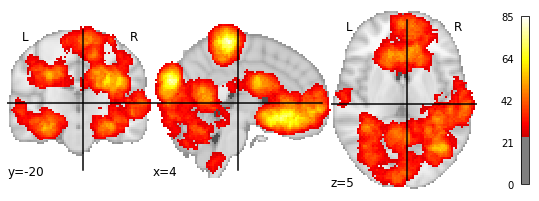

In [9]:
plotting.plot_stat_map(kda_img, threshold=25)
plt.show()

### ALE and KDA limitations [1]

Both ALE and KDA treat each focus independently. As a consequence, if one study has a lot more peaks than the others, this study will have an immense impact on the results, even if the increased number of foci is not relevant and is not indicative of the quality of a study (e.g due to different thresholding). To prevent studies with a lot of peaks from getting the upper hand, MKDA technique does not treat all foci equally and instead, considers study as the unit of analysis. 

### MKDA

The Multilevel Kernel Density Analysis (MKDA) technique, as the name suggests, is closely related to the KDA one. Actually, it is an improved version of KDA in which the unit of analysis is no longer peak location but study. This allows to take down some drawbacks both ALE and KDA have.

#### Pipeline

The MKDA pipeline is  basically the KDA one with extra steps.

The pipeline is summarized in figure [3](#KDA) and can be described as follow.

1. First of all, gather the reported activation peaks in $N$ binary maps.
2. Convolve each of those maps with a spherical kernel of ones.
3. Binarize those maps by setting all strictly positive values to 1 to build the Comparison Indicator Maps (CIM).
3. Derive the MKDA map by performing a weighted average on the CIM (weights are described later).

![ALE](resource/MKDA.png)
<a id='MKDA'></a>**Figure 3**

Let's describe those extra steps.

#### MKDA Kernel

The MKDA kernel is the same as the KDA kernel namely a sphere of ones with a chosen radius $r$ and zero else-where.

#### Binarize

In comparison to KDA, a new step is added between the convolution and the merge operations: binarization. The purpose of this operation is to prevent studies having a lot of peaks from getting the upper hand over studies having only a few peaks, which is, as said before, the problem with ALE and KDA. 

#### Weighted average

The purpose of the average by itself is intuitive but what about the weigthing ?  

1. We want the larger studies to carry more weight in the meta-analysis because it is assumed that the larger the study, the more precise the results.  
2. Moreover, there exist in the litterature two main kinds of studies. The ones which treats subjects as fixed effects (FFX, mostly older studies) and the ones which treats subjecs as random effects (RFX, which are more rigorous). Thus, the idea is to downweight the first kind of studies. There is no absolute value for this but some paper propose 0.75 ([REF]).

In order to match those needs, a reasonable weight for an experiment $n$ is the following:

$$
    \alpha_n = \delta_n\sqrt{S_n}
$$

With
- $S_n$ is the number of subject of the experiment $n$.
- $\delta_n$ the RFX/FFX weight given to experiment $n$ :
$$\delta_n =  \left\{ 
    \begin{array}[cc]\\
        1 & \mbox{if RFX}\\
        .75 & \mbox{if FFX}
    \end{array}
    \right.
  $$

#### Mathematic recap

- Let $N \in \mathbb{N}^*$ the number of experiments/studies.
- Let $S_n \in \mathbb{N}$ the number of subjects in the experiment $n$.
- Let $(N_i, N_j, N_k)$ be the shape of the brain space. Typically $(N_i, N_j, N_k) = (91, 109, 91)$ in the MNI space.
- For all $n \in [1 .. N],$
    * let $B_n \in \{0, 1\}^{N_iN_jN_k}$ be the binary map associated with experiment $n$.
    * let $MA_n \in \mathbb{R}^{N_iN_jN_k}$ be the Modeled Activation map of experiment $n$.
    * let $K_r$ be the uniform kernel of size $r$ associated with experiment $n$.
- Let $MKDA \in \mathbb{R}^{N_iN_jN_k}$ be the wanted MKDA map.

$$
\begin{equation}
    MA_n(i, j, k) = \min((B_n*K_r)(i, j, k),~1)
\end{equation}
$$

$$
\begin{equation}
    MKDA(i, j, k) = \frac{1}{\sum_{n=1}^N\alpha_n}\sum_{n=1}^N\alpha_nMA_n(i, j, k)
\end{equation}
$$

Avec:
$$
    \alpha_n = \delta_n\sqrt{S_n}
$$

$$\delta_n =  \left\{ 
    \begin{array}[cc]\\
        1 & \mbox{if RFX}\\
        .75 & \mbox{if FFX}
    \end{array}
    \right.
$$

#### Inefficient python implementation

In [10]:
r = 10. # mm

def compute_mkda_ma_maps():
    ma_maps = np.zeros((N_img, Ni, Nj, Nk))

    for n in range(N_img):
        print(f'{n+1} out of {N_img}', end='\r')
        binary_img = binary_imgs[n]
        
        # Create probability maps
        binary_arr = binary_img.get_fdata()
        
        prob_arrs = scipy.ndimage.filters.convolve(binary_arr, uniform_kernel(r, affine), mode='constant')
        
        prob_arrs = prob_arrs > 0 

        # Merge probability maps
        ma_maps[n, :, :, :] = prob_arrs
        
    return ma_maps


def merge_mkda_ma_maps(ma_maps):
    return np.sum(ma_maps, axis=0)


mkda_ma_maps = compute_mkda_ma_maps()
mkda_arr = merge_mkda_ma_maps(mkda_ma_maps)
mkda_img = nib.Nifti1Image(mkda_arr, affine)

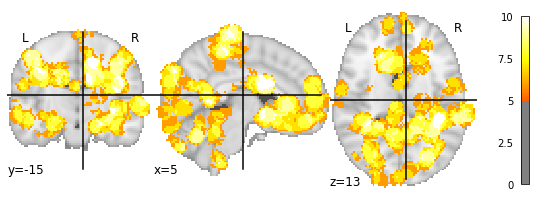

In [11]:
plotting.plot_stat_map(mkda_img, threshold=5)
plt.show()

## Coordinate-based meta-analysis limitations

The main limitation to Coordinate-based meta-analysis is the loss of information between the full image of the brain (which is acquired during the experiment) and the reported coordinates in the published paper. Another limitation of this representation is the high sensitivity of coordinates to methods used in the study, from thresholding to reporting.  
That's why, whenever the full images of the brain is available, one should use Image-based meta-analysis for best results. 

## Image-based meta-analysis (IBMA)

In image-based meta-analysis, as the name suggests, we have at our disposal at least the full activation images of each studies and often the full activation images of each subjects within each studies. The idea of image-based meta-analysis is to mix those maps together to create a meta-analysis map.

We will go through three methods: Fisher, Stouffers and Multilevel GLM. Those methods differ on the way they combine images. Fisher and Stouffers are general methods which are used to combine a number of independant tests, whereas Multilevel GLM is more neuroimaging specific in the way the operation are thought.

**Context**  
What are precisely the input of image-based meta-analysis?  
The type of map (contrast, z, t or standard error maps) depend on the method used and will be detailled in each section. However, whatever it be the type of map, one should be aware about the following.  
Since the input data is now the full brain image instead of coordinates, and since the brain structure varies between subject, it is necessary to put them all in a common space. A solution is to wrap each map onto a common atlas (e.g Talairach). Another is to resample each image to a common template (e.g MNI gray matter).

### Fisher

Fisher's combination method, as Stouffers' one, aims to combine a number of independant tests into one.

**Input data**  
Only the z map of each studies are required.

**Ouput data**  
The ouput of the method is a single p-value map. From this map can be computed a z map, seen as the meta-analysis result.

#### Mathematic foreword
Before applying the Fisher's method to neuroimaging, let's consider the general case.

Let $T_1, ... T_N$ be $N$ independant tests on $H_0$.  
Let $p_1, ..., p_N$ be their corresponding p-values.

The Fisher's method aims to build a test $T_f$ as follow:
$$
    T_f = -2\sum_{k=1}^N\ln(p_k)
$$

An important result is that, under the null hypothesis $H_0$, $T_f$ follows a chi2 distribution with $2N$ degrees of freedom. Thus, the only remaining thing is to compare the obtained value of $T_f$ to the null $\chi^2_{2N}$ distribution. To control for risk of error $\alpha$ one would chose $\chi^2$ value such that under that distribution the propability to find a $\chi^2$ greater or equal to this value is $\alpha$
Large values of $T_f$, less likely according to the $\chi^2_{2N}$ distribution, lead to the rejection of $H_0$.

The p-value $p_f$ of the combined probability test can then be computed by looking to the tail of the $\chi^2_{2N}$ distribution.

$$
    p_f = \mathbb{P}(X \geq T_f)
$$
With
$$
    X \sim \chi^2_{2N}
$$

<img src="resource/chi2.png" width="400">

<a id='Chi2'></a>**Figure 4:** The $\chi^2$ distribution.

#### Neuorimaging application

The key idea is to understand how to transform z maps into p-value maps and vice versa.

**Z map to p-value map**  
Z map store z-scores. For a voxel $v$, the null hypothesis is "the voxel is not activated.". When $H_0$ is true, the z-score of this voxel follows a standard normal distribution. Since we are insterested in activation rather than deactivation, given a z-score $Z$, its associated p-value $p_Z$ is the probability to observe a greater value.

$$
p_Z = \mathbb{P}(X \geq Z)
$$
With
$$X \sim \mathcal{N}(0, 1)$$

Which can be rewritten using the normal cumulative distribution function $\Phi$:
$$
    p_Z = 1 - \Phi(Z)
$$

<img src="resource/normal.jpg" width="300">

<a id='Normal'></a>**Figure 5:** The normal distribution of the z map.

Considering only activation and not deactivation is sometimes referred as one-sided. Considering both of them is also conceivable and referred as two-sided.

**p-value map to Z map**  
Using the inverse normal cumulative distribution function, it is straightforward to invert the previous process. Given a p-value $p$, the associated critical value is:

$$
   Z = \Phi^{-1}(1-p)
$$

**Application**  
Let's consider only one brain voxel $v$. In each study $k$, wondering whether $v$ is activated i.e whether we reject $H_0$ represent a hypothesis test $T_k$. The studies are supposed independant, so are the tests $T_k$. For each study $k$, we can derive the p-value $p_k$ from the z-score associated to voxel $v$ as described previously. We then combine all thoses p-values together to build a test $T_f$. We compare $T_f$ to the $\chi^2_{2N}$ distribution and derive the combined p-value $p_f$. Finally, we derive the meta-analysis z-score from the combined p-value $p_f$ as described above.  
By performing this task voxel-wise, we can derive the meta-analysis z map.

#### Inefficient python implementation

In [12]:
def z_to_p(z_arr):
    return 1-scipy.stats.norm.cdf(z_arr)

def p_to_z(p_arr):
    return scipy.special.ndtri(1-p_arr)

p_values = np.zeros((N_img, Ni, Nj, Nk))

for n in range(N_img):
    img = nilearn.image.load_img(img_paths[n])
    arr = img.get_fdata()
    p_values[n, :, :, :] = z_to_p(arr)
    
    
T_f = -2*np.sum(np.log(p_values), axis=0)
p_f = scipy.stats.chi2.sf(T_f, 2 * N_img)

fisher_arr = p_to_z(p_f)
fisher_img = nib.Nifti1Image(fisher_arr, affine)

/Users/alexandreperez/OneDrive/Documents/Stage/McGill/meta_ALE/venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


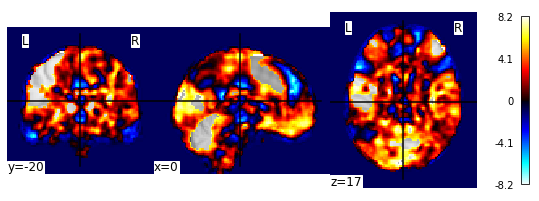

In [13]:
plotting.plot_stat_map(fisher_img)
plt.show()

### Stouffers

Stouffers' method is very close to Fisher's one. Both have z maps as inputs and outputs and both aim to mix p-values maps into one.

**Input data**  
Only the z map of each studies are required.

**Ouput data**  
The ouput of the method is a single p-value map. From this map can be computed a z map, seen as the meta-analysis result.

**Mathematic foreword**

Before applying the Stouffers' method to neuroimaging, let's consider the general case.
  
Let $Z_1, ..., Z_N$ be $N$ Z-scores.

The Stouffers' method aims to build a test $T_s$ as follow:

$$
T_s = \sum_{k=1}^N \frac{Z_k}{\sqrt{N}}
$$

Note that since $Z_k = \Phi^{-1}(1-p_k)$ with the previous notations, it can be seen as a p-value combination method, as Fisher's one.

Z scores follow a standard normal distribution under the null hypothesis. Since $T_s$ is a combination of normal distributions, $T_s \sim \mathcal{N}(0, 1)$.

Under $H_0$, since $Z_k \sim \mathcal{N}(0, 1)$, we have
$$
    \frac{Z_k}{\sqrt{N}} \sim \mathcal{N}(0, \frac{1}{N})
$$
Hence
$$
    T_s = \sum_{k=1}^N \frac{Z_k}{\sqrt{N}} \sim \mathcal{N}(0, 1)
$$

The only remaining thing is to compare the obtained value of $T_s$ to the $\mathcal{N}(0,1)$ distribution. Large values of $T_s$, less likely according to the $\mathcal{N}(0, 1)$ distribution, lead to the rejection of $H_0$.

The p-value $p_s$ of the combined probability test can then be computed by looking to the tail of the $\mathcal{N}(0,1)$ distribution.

$$
    p_s = \mathbb{P}(X \geq T_s)
$$
With
$$
    X \sim \mathcal{N}(0,1)
$$

<img src="resource/normal.png" width="300">

<a id='Normal'></a>**Figure 6:** The normal distribution of the z map.

#### Application
As with Fisher's method, let's consider only one brain voxel $v$. For each study $k$, we can derive the p-value $p_k$ from the z-score associated to voxel $v$ as described previously (See Z map to p-value map section). We then combine all thoses p-values together to build a test $T_s$. We compare $T_s$ to the $\mathcal{N}(0, 1)$ distribution and derive the combined p-value $p_s$. Finally, we derive the meta-analysis z-score from the combined p-value $p_s$ as described above.  
By performing this task voxel-wise, we can derive the meta-analysis z map.

#### Inefficient python implementation

In [14]:
T_s = np.zeros((Ni, Nj, Nk))

for n in range(N_img):
    img = nilearn.image.load_img(img_paths[n])
    T_s += img.get_fdata()
    
T_s /= np.sqrt(N_img)
p_f = scipy.stats.norm.sf(T_s, loc=0, scale=1)

stouffers_arr = p_to_z(p_f)
stouffers_img = nib.Nifti1Image(stouffers_arr, affine)

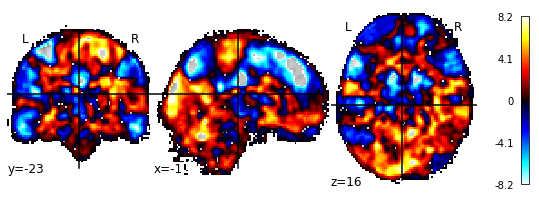

In [15]:
plotting.plot_stat_map(stouffers_img, threshold=0.03)
plt.show()

### Multilevel GLM

The last techniques to be approached is also the more complex: Multilevel General Linear Level. Below is presented a simplified version of it where strong hypothesis have been made.  

The key idea of this technique is to add a level of GLM on top of the other usual levels, that is, adding an inter-study level GLM on top of subject level and within study level GLM.

#### GLM Model
GLM intempts to explain a variable $Y$ as a combination of estimates $\beta$ and noise $e$. The simplest modelisation of GLM is the following:

$$
    Y = X\beta + e
$$

$$e \sim \mathcal{N}(0, \sigma^2 I)$$

Where $Y$, $X$, $e$ are vectors and $X$ a design matrix.

#### Multilevel Model
As a simplified version, we consider only the upper two levels (within study and inter study levels, which are now called 1st and 2nd level) and we take the subject level for ground truth instead of estimation. Here is a summarizing diagram.

**1st level: Within study**  


## Hypothesis testing

Although more interesting than individual maps, the meta-analysis maps derived from the previous methods don't show their full potential. It remains to differentiate the true signal of the noise given a tolerance $\alpha$ thanks to hypothesis testing. One way of doing this is to use the permutation testing method (note that other methods exist such as Monte Carlo simulations).

#### Permutation testing

The key idea of permutation testing is to permute the labels of the experiments to generate a null distribution. From the former can be derived an appropriate threshold at the wanted tolerance rate.

**What labels are we talking about?**  

Let's say you have a number $N_a$ of studies related to the same topic (e.g language) and a number $N_b$ of studies dealing with varied other topics. To generate a null distribution, permute randomly the labels of the studies (e.g language related and non language related studies) and apply the same meta-analysis method on the newly created set of $N_a$ studies labelled as your initial topic (e.g language). By doing so a large number of times, the null distribution is derived.

**What if I don't have any studies unrelated to my topic of interest?**

A way of using the permutation testing method even with single topic related studies is to generate false unrelated studies by taking the opposite of the contrasts (since contrasts follows a normal distribution under the null hypothesis which is sign invariant). Instead of permuting labels with another set of unrelated studies that we don't have, we randomly flip the sign of studies in our original set. Then, we apply the same meta-analysis method on the newly created set of studies. By doing so a large number of times, the null distribution is derived.

**What do we do after obtaining the null distribution?**  

Once obtained the null distribution, two well-known error controls are the False Discovery Rate (FDR) and Family Wise Error Rate (FWER). Whether to prefer the FDR or FWER control rate depends on the meta-analysis method used and will be discussed later.

**FDR or FWER?**
Here are some recommandations found in the litterature[].

| Method | Error rate  |
|:--------:|:-------------:|
|ALE     | FDR         |
|KDA     | FWER        |
|MKDA    | FWER (recommended) or FDR|


# Meta-analysis using NiMARE

The purpose of this section is to show the use of NiMARE to perform the meta-analysis techniques we just presented in the notebook.

## 1. Build the NiMARE.Dataset object

In order to be able to use the NiMARE package, we need a little more work done on the data to be accepted as input by NiMARE. The following functions build the dictionnary input used buy NiMARE. 

In [16]:
def get_sub_dict(XYZ, path_dict):
    """
    Build sub dictionnary of a study using the nimare structure.

    Args:
        XYZ (tuple): Size 3 tuple of list storing the X Y Z coordinates.
        path_dict (dict): Dict which has map name ('t', 'z', 'con', 'se')
            as keys and absolute path to the image as values.

    Returns:
        (dict): Dictionary storing the coordinates for a
            single study using the Nimare structure.

    """
    d = {
        'contrasts': {
            '0': {
                'metadata': {'sample_sizes': 119}
            }
        }
    }

    if XYZ is not None:
        d['contrasts']['0']['coords'] = {
                    'x': list(XYZ[0]),
                    'y': list(XYZ[1]),
                    'z': list(XYZ[2]),
                    'space': 'MNI'
                    }
        d['contrasts']['0']['sample_sizes'] = 119

    if path_dict is not None:
        d['contrasts']['0']['images'] = path_dict

    return d


def extract_from_paths(paths, data=['coord', 'path'],
                       threshold=1.96, tag=None, load=True):
    """
    Extract data from given images.

    Extract data (coordinates, paths...) from the data and put it in a
        dictionnary using Nimare structure.

    Args:
        path_dict (dict): Dict which keys are study names and values
            absolute paths (string).
        data (list): Data to extract. 'coord' and 'path' available.
        threshold (float): value below threshold are ignored. Used for
            peak detection.
        tag (str): Name of the file to load/dump.
        load (bool): If True, load a potential existing result.
            If False or not found, compute again.

    Returns:
        (dict): Dictionnary storing the coordinates using the Nimare
            structure.

    """
    if tag is not None:
        # Loading previously computed dict if any
        ds_dict = pickle_load(save_dir+tag, load=load)
        if ds_dict is not None:
            return ds_dict

    # Computing a new dataset dictionary
    def extract_pool(path):
        """Extract activation for multiprocessing."""
        print(f'Extracting {path}...')

        XYZ = None
        if 'coord' in data:
            XYZ = get_activations(path, threshold, space='pos')
            if XYZ is None:
                return

        if 'path' in data:
            base, filename = ntpath.split(path)
            file, ext = filename.split('.', 1)

            path_dict = {'z': path}
            for map_type in ['t', 'con', 'se']:
                file_path = f'{base}/{file}_{map_type}.{ext}'
                if os.path.isfile(file_path):
                    path_dict[map_type] = file_path

            return get_sub_dict(XYZ, path_dict)

        if XYZ is not None:
            return get_sub_dict(XYZ, None)

        return

    n_jobs = multiprocessing.cpu_count()
    res = Parallel(n_jobs=n_jobs, backend='threading')(
        delayed(extract_pool)(path) for path in paths)

    # Removing potential None values
    res = list(filter(None, res))
    # Merging all dictionaries
    ds_dict = {k: v for k, v in enumerate(res)}

    if tag is not None:
        pickle_dump(ds_dict, save_dir+tag)  # Dumping
    return ds_dict

In [17]:
ds_dict = extract_from_paths(img_paths, data=['path', 'coord'], threshold=1.96)

Extracting /Users/alexandreperez/OneDrive/Documents/Stage/McGill/meta_ALE/data-narps/proc/hypo1_unthresh_0.nii.gz...
Extracting /Users/alexandreperez/OneDrive/Documents/Stage/McGill/meta_ALE/data-narps/proc/hypo1_unthresh_1.nii.gz...Extracting /Users/alexandreperez/OneDrive/Documents/Stage/McGill/meta_ALE/data-narps/proc/hypo1_unthresh_2.nii.gz...
Extracting /Users/alexandreperez/OneDrive/Documents/Stage/McGill/meta_ALE/data-narps/proc/hypo1_unthresh_3.nii.gz...
Extracting /Users/alexandreperez/OneDrive/Documents/Stage/McGill/meta_ALE/data-narps/proc/hypo1_unthresh_4.nii.gz...
Extracting /Users/alexandreperez/OneDrive/Documents/Stage/McGill/meta_ALE/data-narps/proc/hypo1_unthresh_5.nii.gz...Extracting /Users/alexandreperez/OneDrive/Documents/Stage/McGill/meta_ALE/data-narps/proc/hypo1_unthresh_6.nii.gz...

Extracting /Users/alexandreperez/OneDrive/Documents/Stage/McGill/meta_ALE/data-narps/proc/hypo1_unthresh_7.nii.gz...

Extracting /Users/alexandreperez/OneDrive/Documents/Stage/McGill

In [18]:
print(ds_dict)

{0: {'contrasts': {'0': {'metadata': {'sample_sizes': 119}, 'coords': {'x': [12.0, -48.0, -4.0, 38.0, -30.0, -6.0, 36.0, -4.0, -6.0, -40.0, 6.0, 16.0, 48.0, 6.0, -24.0, -12.0, 26.0, -8.0, -2.0, -60.0, -38.0, 0.0, 36.0, 12.0, -2.0, -2.0, 0.0, -50.0, -56.0, 60.0, 66.0, -42.0, -10.0, 54.0, -42.0, -10.0, 28.0, 52.0, -24.0, 12.0, 8.0, 22.0, -8.0, -18.0, 10.0, -6.0, 18.0, -60.0, 4.0, -2.0, 8.0, 38.0, 28.0, 16.0, 18.0, 12.0, 14.0, -48.0, -22.0, 16.0, -18.0, 34.0, 12.0, -22.0, -16.0, 8.0, 0.0, -24.0, -18.0, 36.0, -22.0, 30.0, 18.0, 22.0, -20.0, -18.0, 20.0, 22.0, -2.0, -40.0, -40.0, -28.0, 60.0, 42.0, -36.0, 22.0, -18.0, -10.0, -18.0, -46.0, 70.0, 0.0, 56.0, 14.0, 8.0, -26.0, 54.0, -26.0, -22.0, 32.0, 28.0, 6.0, 22.0, -36.0, 16.0, 32.0, 32.0, 58.0, 24.0, 28.0, -32.0, 40.0, -42.0, -12.0, 0.0, 42.0, 20.0, -40.0, 42.0, -22.0, -2.0, -44.0, -38.0, 8.0, -4.0, -38.0, 26.0, 12.0, -18.0, 66.0, -38.0, -22.0, 40.0, 26.0, 42.0, 24.0, -32.0], 'y': [-36.0, -16.0, -54.0, -14.0, -32.0, -52.0, -16.0, 16.0, 32.

## Run meta-analysis on data

In [19]:
def run_ALE(ds_dict):
    """Run ALE on given data."""
    ds = Dataset(ds_dict)
    ma = nimare.meta.cbma.ale.ALE()
    res = ma.fit(ds)

    img_ale = res.get_map('ale')
    img_p = res.get_map('p')
    img_z = res.get_map('z')

    return img_ale, img_p, img_z


def run_KDA(ds_dict):
    """Run KDA on given data."""
    ds = Dataset(ds_dict)
    ma = nimare.meta.cbma.mkda.KDA()
    res = ma.fit(ds)

    return res.get_map('of')


def run_MKDA(ds_dict):
    """Run KDA on given data."""
    ds = Dataset(ds_dict)
    ma = nimare.meta.cbma.mkda.MKDADensity()
    res = ma.fit(ds)

    return res.get_map('of')


def run_MFX_GLM(ds_dict):
    """Run MFX_GLM on given data."""
    ds = Dataset(ds_dict)
    ma = nimare.meta.ibma.MFX_GLM()
    res = ma.fit(ds)

    return res.get_map('t')


def run_Fishers(ds_dict):
    """Run Fishers on given data."""
    ds = Dataset(ds_dict)
    ma = nimare.meta.ibma.Fishers()
    res = ma.fit(ds)

    return res.get_map('z')


def run_Stouffers(ds_dict):
    """Run Stouffers on given data."""
    ds = Dataset(ds_dict)
    ma = nimare.meta.ibma.Stouffers()
    res = ma.fit(ds)

    return res.get_map('z')


def fdr_threshold(img_list, img_p, q=0.05):
    """Compute FDR and threshold same-sized images."""
    arr_list = [copy.copy(img.get_fdata()) for img in img_list]
    arr_p = img_p.get_fdata()
    aff = img_p.affine

    fdr = nimare.stats.fdr(arr_p.ravel(), q=q)

    for arr in arr_list:
        arr[arr_p > fdr] = 0

    res_list = [nib.Nifti1Image(arr, aff) for arr in arr_list]

    return res_list

In [20]:
img_ale, img_p, img_z = run_ALE(ds_dict)
img_kda = run_KDA(ds_dict)
img_mkda = run_MKDA(ds_dict)
img_z_F = run_Fishers(ds_dict)
img_z_S = run_Stouffers(ds_dict)
img_t_MFX = run_MFX_GLM(ds_dict)

INFO:nimare.dataset:Shared path detected: "/Users/alexandreperez/OneDrive/Documents/Stage/McGill/meta_ALE/data-narps/proc/hypo1_unthresh_"
INFO:nimare.dataset:Shared path detected: "/Users/alexandreperez/OneDrive/Documents/Stage/McGill/meta_ALE/data-narps/proc/hypo1_unthresh_"
INFO:nimare.dataset:Shared path detected: "/Users/alexandreperez/OneDrive/Documents/Stage/McGill/meta_ALE/data-narps/proc/hypo1_unthresh_"
INFO:nimare.dataset:Shared path detected: "/Users/alexandreperez/OneDrive/Documents/Stage/McGill/meta_ALE/data-narps/proc/hypo1_unthresh_"
INFO:nimare.dataset:Shared path detected: "/Users/alexandreperez/OneDrive/Documents/Stage/McGill/meta_ALE/data-narps/proc/hypo1_unthresh_"
INFO:nimare.dataset:Shared path detected: "/Users/alexandreperez/OneDrive/Documents/Stage/McGill/meta_ALE/data-narps/proc/hypo1_unthresh_"


191011-11:34:33,263 nipype.interface INFO:
	 stdout 2019-10-11T11:34:33.263686:Log directory is: stats


INFO:nipype.interface:stdout 2019-10-11T11:34:33.263686:Log directory is: stats


191011-11:34:33,266 nipype.interface INFO:
	 stdout 2019-10-11T11:34:33.266295:Setting up:


INFO:nipype.interface:stdout 2019-10-11T11:34:33.266295:Setting up:


191011-11:34:33,778 nipype.interface INFO:
	 stdout 2019-10-11T11:34:33.778649:ntptsing=10.000000 


INFO:nipype.interface:stdout 2019-10-11T11:34:33.778649:ntptsing=10.000000 


191011-11:34:33,779 nipype.interface INFO:
	 stdout 2019-10-11T11:34:33.778649:


INFO:nipype.interface:stdout 2019-10-11T11:34:33.778649:


191011-11:34:33,781 nipype.interface INFO:
	 stdout 2019-10-11T11:34:33.778649:evs_group=1.000000 


INFO:nipype.interface:stdout 2019-10-11T11:34:33.778649:evs_group=1.000000 


191011-11:34:33,782 nipype.interface INFO:
	 stdout 2019-10-11T11:34:33.778649:


INFO:nipype.interface:stdout 2019-10-11T11:34:33.778649:


191011-11:34:33,783 nipype.interface INFO:
	 stdout 2019-10-11T11:34:33.783745:No f contrasts


INFO:nipype.interface:stdout 2019-10-11T11:34:33.783745:No f contrasts


191011-11:34:33,838 nipype.interface INFO:
	 stdout 2019-10-11T11:34:33.838572:


INFO:nipype.interface:stdout 2019-10-11T11:34:33.838572:


191011-11:34:33,840 nipype.interface INFO:
	 stdout 2019-10-11T11:34:33.838572:WARNING: The passed in varcope file, /Users/alexandreperez/OneDrive/Documents/Stage/McGill/meta_ALE/mfx_glm/varcope.nii.gz, contains voxels inside the mask with zero (or negative) values. These voxels will be excluded from the analysis.


INFO:nipype.interface:stdout 2019-10-11T11:34:33.838572:WARNING: The passed in varcope file, /Users/alexandreperez/OneDrive/Documents/Stage/McGill/meta_ALE/mfx_glm/varcope.nii.gz, contains voxels inside the mask with zero (or negative) values. These voxels will be excluded from the analysis.


191011-11:34:33,846 nipype.interface INFO:
	 stdout 2019-10-11T11:34:33.846866:nevs=1


INFO:nipype.interface:stdout 2019-10-11T11:34:33.846866:nevs=1


191011-11:34:33,848 nipype.interface INFO:
	 stdout 2019-10-11T11:34:33.846866:ntpts=10


INFO:nipype.interface:stdout 2019-10-11T11:34:33.846866:ntpts=10


191011-11:34:33,849 nipype.interface INFO:
	 stdout 2019-10-11T11:34:33.846866:ngs=1


INFO:nipype.interface:stdout 2019-10-11T11:34:33.846866:ngs=1


191011-11:34:33,850 nipype.interface INFO:
	 stdout 2019-10-11T11:34:33.846866:nvoxels=227461


INFO:nipype.interface:stdout 2019-10-11T11:34:33.846866:nvoxels=227461


191011-11:34:33,879 nipype.interface INFO:
	 stdout 2019-10-11T11:34:33.878976:Running:


INFO:nipype.interface:stdout 2019-10-11T11:34:33.878976:Running:


191011-11:34:33,880 nipype.interface INFO:
	 stdout 2019-10-11T11:34:33.878976:nmaskvoxels=227461


INFO:nipype.interface:stdout 2019-10-11T11:34:33.878976:nmaskvoxels=227461


191011-11:34:46,0 nipype.interface INFO:
	 stdout 2019-10-11T11:34:46.000491: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100


INFO:nipype.interface:stdout 2019-10-11T11:34:46.000491: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100


191011-11:34:46,4 nipype.interface INFO:
	 stdout 2019-10-11T11:34:46.004505:nmaskvoxels=227461


INFO:nipype.interface:stdout 2019-10-11T11:34:46.004505:nmaskvoxels=227461


191011-11:34:46,5 nipype.interface INFO:
	 stdout 2019-10-11T11:34:46.004505:Saving results


INFO:nipype.interface:stdout 2019-10-11T11:34:46.004505:Saving results


191011-11:34:47,682 nipype.interface INFO:
	 stdout 2019-10-11T11:34:47.682023:


INFO:nipype.interface:stdout 2019-10-11T11:34:47.682023:


191011-11:34:47,683 nipype.interface INFO:
	 stdout 2019-10-11T11:34:47.682023:Log directory was: stats


INFO:nipype.interface:stdout 2019-10-11T11:34:47.682023:Log directory was: stats


191011-11:34:48,189 nipype.interface INFO:
	 stdout 2019-10-11T11:34:48.189200:DLH 0.0420337


INFO:nipype.interface:stdout 2019-10-11T11:34:48.189200:DLH 0.0420337


191011-11:34:48,191 nipype.interface INFO:
	 stdout 2019-10-11T11:34:48.189200:VOLUME 227461


INFO:nipype.interface:stdout 2019-10-11T11:34:48.189200:VOLUME 227461


191011-11:34:48,192 nipype.interface INFO:
	 stdout 2019-10-11T11:34:48.189200:RESELS 117.774


INFO:nipype.interface:stdout 2019-10-11T11:34:48.189200:RESELS 117.774


191011-11:34:48,194 nipype.interface INFO:
	 stdout 2019-10-11T11:34:48.189200:FWHMvoxel 4.87311 4.87311 4.87311


INFO:nipype.interface:stdout 2019-10-11T11:34:48.189200:FWHMvoxel 4.87311 4.87311 4.87311


191011-11:34:48,195 nipype.interface INFO:
	 stdout 2019-10-11T11:34:48.189200:FWHMmm 9.74622 9.83629 9.82811


INFO:nipype.interface:stdout 2019-10-11T11:34:48.189200:FWHMmm 9.74622 9.83629 9.82811


191011-11:34:48,371 nipype.interface INFO:
	 stdout 2019-10-11T11:34:48.371155:Cluster Index	Voxels	P	-log10(P)	MAX	MAX X (mm)	MAX Y (mm)	MAX Z (mm)	COG X (mm)	COG Y (mm)	COG Z (mm)	COPE-MAX	COPE-MAX X (mm)	COPE-MAX Y (mm)	COPE-MAX Z (mm)	COPE-MEAN


INFO:nipype.interface:stdout 2019-10-11T11:34:48.371155:Cluster Index	Voxels	P	-log10(P)	MAX	MAX X (mm)	MAX Y (mm)	MAX Z (mm)	COG X (mm)	COG Y (mm)	COG Z (mm)	COPE-MAX	COPE-MAX X (mm)	COPE-MAX Y (mm)	COPE-MAX Z (mm)	COPE-MEAN


191011-11:34:48,373 nipype.interface INFO:
	 stdout 2019-10-11T11:34:48.371155:3	18572	1.4e-44	43.8	4.83	-42	-48	-10	10.2	-43.5	25.3	3.31	-48	-56	-12	1.42


INFO:nipype.interface:stdout 2019-10-11T11:34:48.371155:3	18572	1.4e-44	43.8	4.83	-42	-48	-10	10.2	-43.5	25.3	3.31	-48	-56	-12	1.42


191011-11:34:48,374 nipype.interface INFO:
	 stdout 2019-10-11T11:34:48.371155:2	2495	5.61e-11	10.3	4.55	-42	-14	48	-28.4	3.01	22.9	4.18	-44	-18	48	1.52


INFO:nipype.interface:stdout 2019-10-11T11:34:48.371155:2	2495	5.61e-11	10.3	4.55	-42	-14	48	-28.4	3.01	22.9	4.18	-44	-18	48	1.52


191011-11:34:48,376 nipype.interface INFO:
	 stdout 2019-10-11T11:34:48.371155:1	649	0.000671	3.17	4.39	12	10	-8	14.9	21.5	-2.36	2.19	12	10	-8	1.24


INFO:nipype.interface:stdout 2019-10-11T11:34:48.371155:1	649	0.000671	3.17	4.39	12	10	-8	14.9	21.5	-2.36	2.19	12	10	-8	1.24


191011-11:34:48,892 nipype.interface INFO:
	 stdout 2019-10-11T11:34:48.891911:Cluster Index	Voxels	P	-log10(P)	MAX	MAX X (mm)	MAX Y (mm)	MAX Z (mm)	COG X (mm)	COG Y (mm)	COG Z (mm)	COPE-MAX	COPE-MAX X (mm)	COPE-MAX Y (mm)	COPE-MAX Z (mm)	COPE-MEAN


INFO:nipype.interface:stdout 2019-10-11T11:34:48.891911:Cluster Index	Voxels	P	-log10(P)	MAX	MAX X (mm)	MAX Y (mm)	MAX Z (mm)	COG X (mm)	COG Y (mm)	COG Z (mm)	COPE-MAX	COPE-MAX X (mm)	COPE-MAX Y (mm)	COPE-MAX Z (mm)	COPE-MEAN


191011-11:34:48,894 nipype.interface INFO:
	 stdout 2019-10-11T11:34:48.891911:6	4008	2.04e-15	14.7	4.64	-4	44	36	-5.62	35.5	44.9	3.63	-10	32	60	1.82


INFO:nipype.interface:stdout 2019-10-11T11:34:48.891911:6	4008	2.04e-15	14.7	4.64	-4	44	36	-5.62	35.5	44.9	3.63	-10	32	60	1.82


191011-11:34:48,895 nipype.interface INFO:
	 stdout 2019-10-11T11:34:48.891911:5	1843	8.58e-09	8.07	4.72	-58	-16	-26	-59.6	-30.8	-11.3	3.29	-56	-10	-28	1.74


INFO:nipype.interface:stdout 2019-10-11T11:34:48.891911:5	1843	8.58e-09	8.07	4.72	-58	-16	-26	-59.6	-30.8	-11.3	3.29	-56	-10	-28	1.74


191011-11:34:48,897 nipype.interface INFO:
	 stdout 2019-10-11T11:34:48.891911:4	1797	1.25e-08	7.9	4.82	-42	42	-14	-45.6	30.5	-3.46	3.94	-50	38	-12	2.09


INFO:nipype.interface:stdout 2019-10-11T11:34:48.891911:4	1797	1.25e-08	7.9	4.82	-42	42	-14	-45.6	30.5	-3.46	3.94	-50	38	-12	2.09


191011-11:34:48,898 nipype.interface INFO:
	 stdout 2019-10-11T11:34:48.891911:3	1284	1.07e-06	5.97	4.4	-52	-58	48	-51.3	-55.7	41.4	3.51	-50	-62	48	2.18


INFO:nipype.interface:stdout 2019-10-11T11:34:48.891911:3	1284	1.07e-06	5.97	4.4	-52	-58	48	-51.3	-55.7	41.4	3.51	-50	-62	48	2.18


191011-11:34:48,899 nipype.interface INFO:
	 stdout 2019-10-11T11:34:48.899959:2	934	3.09e-05	4.51	4.56	54	-60	42	54	-53.9	40.3	2.91	54	-58	46	1.94


INFO:nipype.interface:stdout 2019-10-11T11:34:48.899959:2	934	3.09e-05	4.51	4.56	54	-60	42	54	-53.9	40.3	2.91	54	-58	46	1.94


191011-11:34:48,901 nipype.interface INFO:
	 stdout 2019-10-11T11:34:48.899959:1	465	0.00624	2.2	3.99	58	-22	-18	64.1	-32.8	-9.93	2.02	62	-22	-22	1.37


INFO:nipype.interface:stdout 2019-10-11T11:34:48.899959:1	465	0.00624	2.2	3.99	58	-22	-18	64.1	-32.8	-9.93	2.02	62	-22	-22	1.37
INFO:nimare.meta.ibma:Cleaning up...


In [21]:
img_ale_thr, img_p_thr, img_z_thr = fdr_threshold([img_ale, img_p, img_z], img_p)

## Print results

In [22]:
meta_analysis = { 
    'ALE': img_ale,
    #'p': img_p,
    #'z': img_z,
    'ALE thresholded': img_ale_thr,
    #'p thresholded': img_p_thr,
    #'z thresholded': img_z_thr,
    'KDA': img_kda,
    'MKDA': img_mkda,
    'z Fishers': img_z_F,
    'z Stouffers': img_z_S,
    't MFX': img_t_MFX,
}

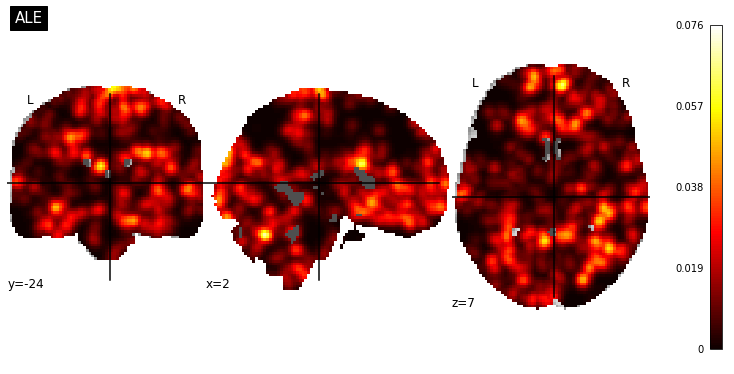

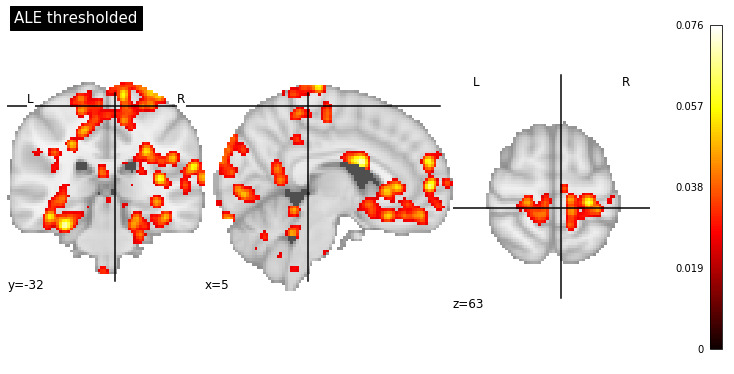

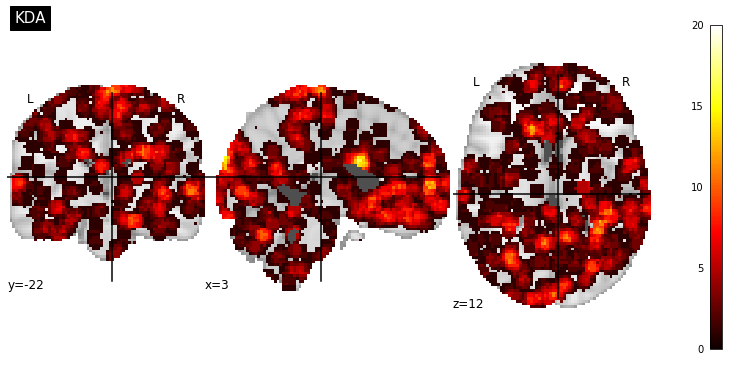

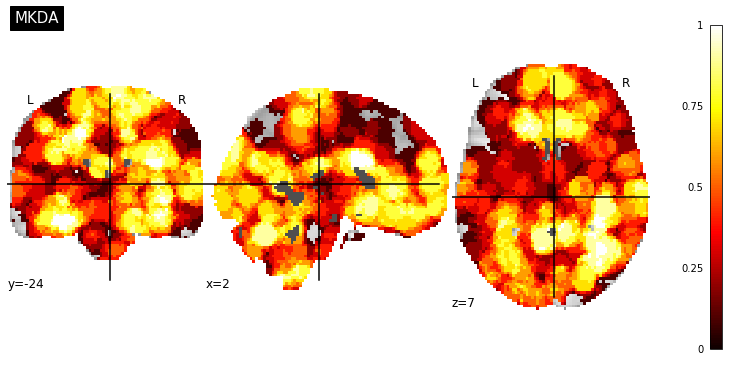

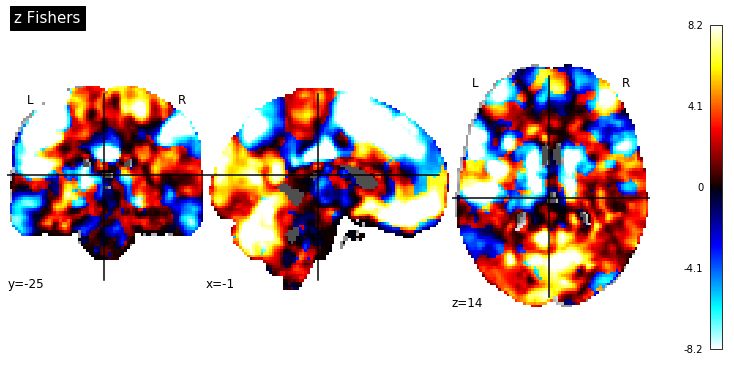

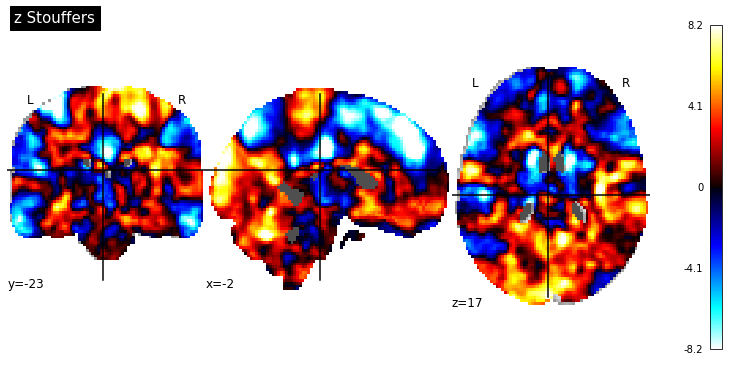

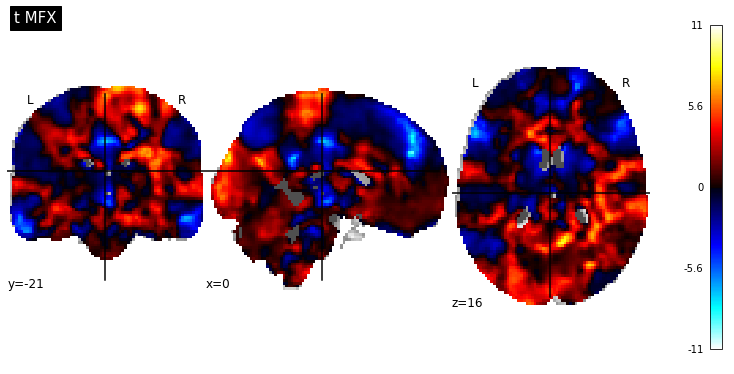

In [23]:
for name, img in meta_analysis.items():
    plotting.plot_stat_map(img, title=name, figure=plt.figure(figsize=(10,5)))

# References

[] Meta-analysis of functional neuroimaging data: current and future directions  
Tor D. Wager, Martin Lindquist, and Lauren Kaplan

[?] Meta-analysis of neuroimaging data: A comparison of image-based and coordinate-based pooling of studies  
    Gholamreza Salimi-Khorshidi, Stephen M. Smith, John R. Keltner, Tor D. Wager, Thomas E. Nichols 
    
[] Combining Brains: A Survey of Methods for Statistical Pooling of Information  
    Nicole A. Lazar, Beatriz Luna, John A. Sweeney, and William F. Eddy
    
[] General multilevel linear modeling for group analysis in FMRI  
Christian F. Beckmann, Mark Jenkinson, and Stephen M. Smith

[] NiMARE: https://github.com/neurostuff/NiMARE